 В данной работе я использовал библиотеку pandas, для импорта и анализа данных из excel файла и библиотеку matplotlib для отрисовки графиков.

 Критерии отбора фрод операций:
 1. Большое количество транзакций с одного айпи адреса и карты в единицу времени
 2. Много различных IP адресов для одной карты
 3. Много карт для одного IP адреса
 
 Таким образом мы можем вычислить кто производит фрод транзакции и тем самым защитить мерчантов от фрода

In [58]:
import pandas as pd
import openpyxl
import sqlite3
import matplotlib
from matplotlib import pyplot as plt



Найдём самых популярных мерчантов

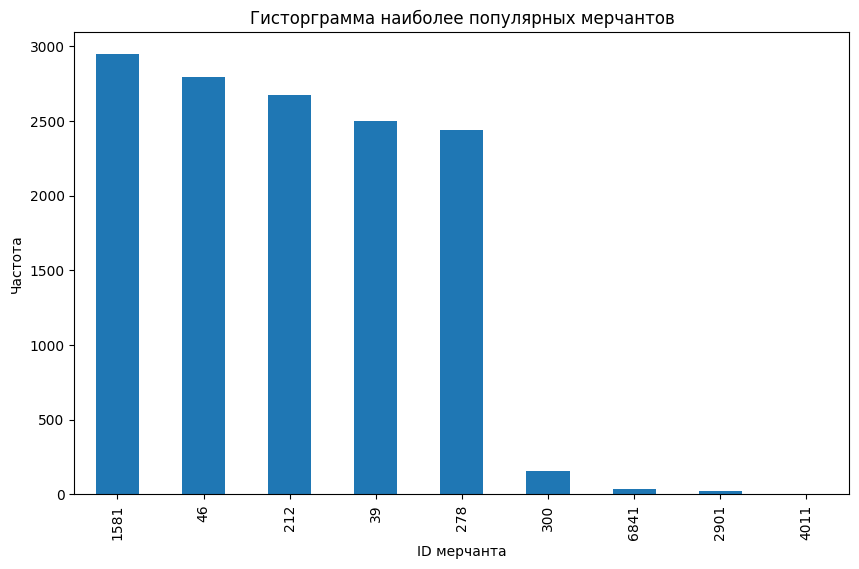

In [59]:



df = pd.read_excel('data.xlsx', sheet_name='sheet1')
n = 100

top_n_sum = df['Merchant ID'].value_counts().head(n)

plt.figure(figsize=(10,6))
top_n_sum.plot(kind='bar')
plt.title('Гисторграмма наиболее популярных мерчантов')
plt.xlabel('ID мерчанта')
plt.ylabel('Частота')
plt.show()

Одним из маркеров фродовых транзакций является, большое количество транзакций с одной карты, одного ip, в единицу времени

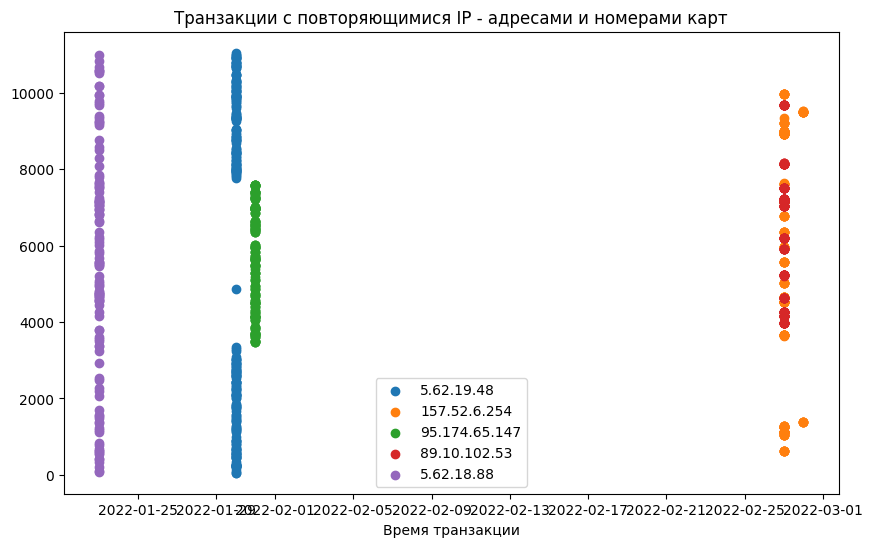

In [60]:




ip_counts = df['Customer IP V4 V6'].value_counts()
card_counts = df['Account Number'].value_counts()

duplicated_cards = card_counts[card_counts>1].index.tolist()
top_ips=ip_counts.head().index.tolist()

df_top_cards = df[df['Account Number'].isin(duplicated_cards)]
df_top_ips=df[df['Customer IP V4 V6'].isin(top_ips)]


plt.figure(figsize=(10, 6))
for ip in top_ips:
    df_ip = df_top_ips[df_top_ips['Customer IP V4 V6'] == ip]
    
    plt.scatter(df_ip['Operation created at Date'], df_ip.index, label=ip)
for card in duplicated_cards:
    df_card = df_top_cards[df_top_cards['Account Number']== card]
    
    
    

plt.title('Транзакции c повторяющимися IP - адресами и номерами карт')
plt.xlabel('Время транзакции')
plt.legend()
plt.show()




Найдём связи между найденными ip адресами, выявим самого популярного мерчанта среди них

In [61]:

frod_ips = ['5.62.18.88', '157.52.6.254','95.174.35.147','89.10.102.53','5.62.19.48']
filter = df[df['Customer IP V4 V6'].isin(frod_ips)]
grouped = filter.groupby(['Customer IP V4 V6', 'Provider ID','Merchant ID', 'Customer ID']).size().reset_index(name='count')
grouped


,Customer IP V4 V6,Provider ID,Merchant ID,Customer ID,count
0,157.52.6.254,1293.0,1581,134623,181
1,5.62.18.88,1293.0,278,8ba8aa0ac77133680329648aaad0109c,10
2,5.62.19.48,1293.0,1581,133367,155
3,5.62.19.48,1431.0,1581,133367,7
4,5.62.19.48,1941.0,1581,133367,9
5,89.10.102.53,1293.0,1581,27112,169


Ещё одним сценарием фродовых транзакций является, большое количество разных ip адресов для одной карты, в следующей диаграмме я подобрал те карты, у которых более 7 уникальных IP адресов.

Account Number
422074******8630    38
430589******8005    16
443910******8906    11
474503******6575    15
494019******8895     8
521729******8680    17
536774******3520    15
539941******8089     9
Name: Customer IP V4 V6, dtype: int64


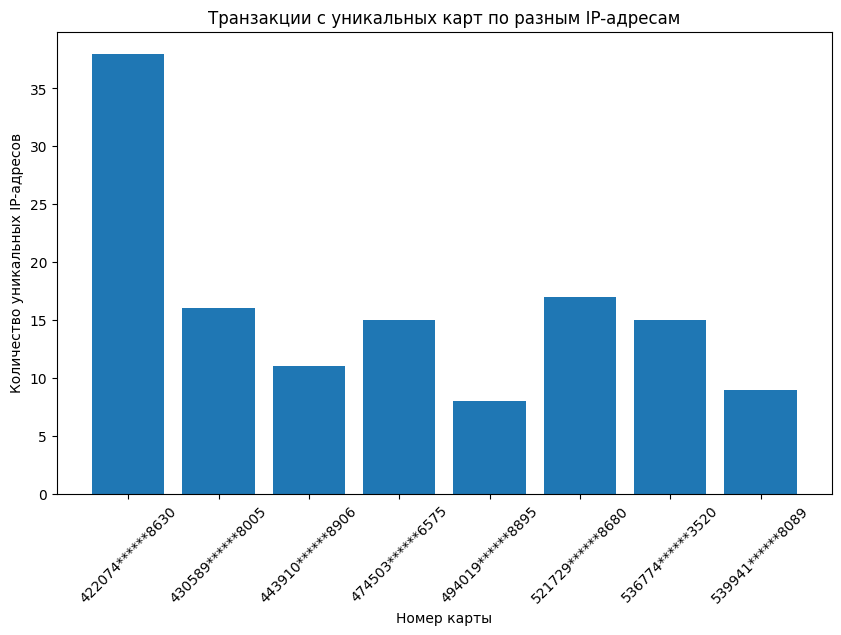

In [62]:
ips1 = df.groupby('Account Number')['Customer IP V4 V6'].nunique()

filter=df[df['Account Number'].isin(ips1[ips1>7].index)]

ips1 = filter.groupby('Account Number')['Customer IP V4 V6'].nunique()

print(ips1)
plt.figure(figsize=(10, 6))
plt.bar(ips1.index, ips1.values)
plt.xlabel('Номер карты')
plt.ylabel('Количество уникальных IP-адресов')
plt.title('Транзакции с уникальных карт по разным IP-адресам')
plt.xticks(rotation=45)
plt.show()

Сгруппируем по мерчантам и Ip адресам

In [63]:
card_list = ['422074******8630', '430589******8005','443910******8906','474503******6575', '494019******8895','521729******8680', '536774******3520','539941******8089']
filter = df[df['Account Number'].isin(card_list)] 
grouped = filter.groupby(['Account Number','Customer IP V4 V6', 'Provider ID','Merchant ID', 'Customer ID','Operation Status']).size().reset_index(name='count')
grouped.to_csv('./tmp3')
grouped





,Account Number,Customer IP V4 V6,Provider ID,Merchant ID,Customer ID,Operation Status,count
0,422074******8630,185.171.126.102,1293.0,46,348231,success,3
1,422074******8630,185.171.126.105,1293.0,46,348231,success,1
2,422074******8630,185.171.126.106,1293.0,46,348231,success,1
3,422074******8630,185.171.126.118,1293.0,46,348231,success,4
4,422074******8630,185.171.126.12,1293.0,46,348231,success,3
...,...,...,...,...,...,...,...
180,539941******8089,197.210.55.103,1293.0,46,345042,decline,1
181,539941******8089,197.210.55.43,1293.0,46,345042,success,1
182,539941******8089,197.210.79.118,1293.0,46,345042,decline,3
183,539941******8089,197.210.85.20,1293.0,46,345042,decline,1


 В следующем случае я рассматриваю обратную ситуацию, когда на один ip адрес приходится несколько карт, это показатель ещё одного из возможных проведений фрод операций.

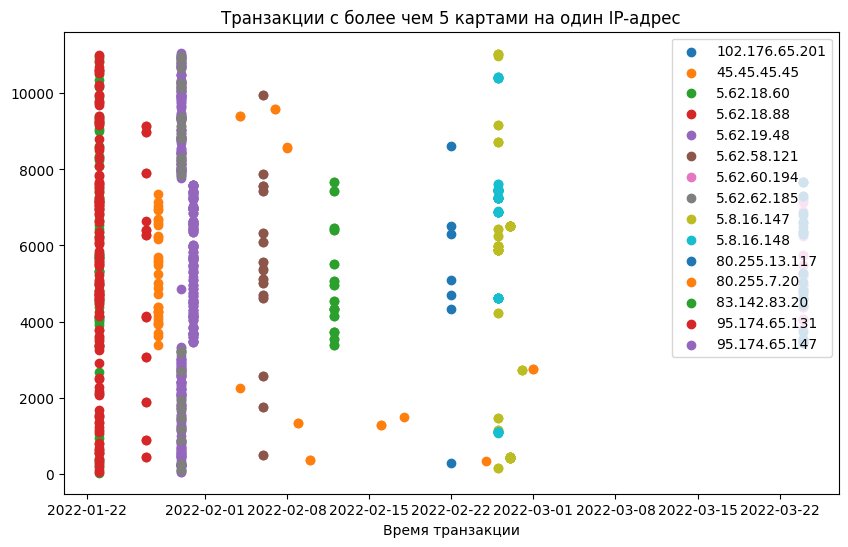

In [70]:
ip_counts = df['Customer IP V4 V6'].value_counts()
card_counts = df.groupby('Customer IP V4 V6')['Account Number'].nunique()

ip_with_multiple_cards = card_counts[card_counts > 5].index.tolist()

df_filtered = df[df['Customer IP V4 V6'].isin(ip_with_multiple_cards)]

plt.figure(figsize=(10, 6))
for ip in ip_with_multiple_cards:
    df_ip = df_filtered[df_filtered['Customer IP V4 V6'] == ip]
    plt.scatter(df_ip['Operation created at Date'], df_ip.index, label=ip)

plt.title('Транзакции с более чем 5 картами на один IP-адрес')
plt.xlabel('Время транзакции')
plt.legend()
plt.show()

Проанализировав транзакции мы видим схожести с самым первым нашим поиском фрод транзакций по ip адресам 5.62.18.88, 5.62.19.48 скорее всего с этих адресов проводятся фрод транзакции и провайдерам стоит присмотреться к данным адресам для защиты мерчантов от фрода



Далее, я решил найти количество фродовых транзакций от общего потока транзакций, проанализировав совпадения в строках разных датафреймов

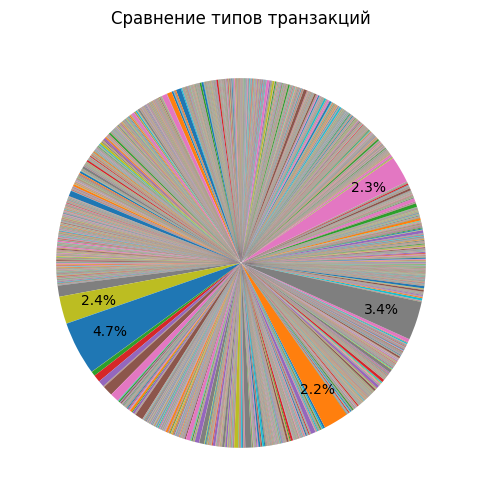

In [80]:

merged_df = pd.concat([df, df_top_ips, df_filtered, grouped])


grouped_data = merged_df.groupby('Customer IP V4 V6').size()  
labels = grouped_data.index.tolist()  
values = grouped_data.values.tolist()  


plt.figure(figsize=(8, 6))
plt.pie(values, autopct=lambda p: f'{p:.1f}%' if p > 1 else '', pctdistance=0.8)
plt.title('Сравнение типов транзакций')

plt.show()


По итогу могу предложить провайдерам несколько решений проблем
1. Обязательная верификация по 3ds Check
2. Бан по IP при большом количестве транзакций с него
3. Обязательная верификация по имени и запрет на использование платёжных систем с простой регистрацией через номер

Провайдер уже использует механизмы по противодействию фроду, такие как отклонение операций которые происходят в большом количестве в единицу времени, но их недостаточно для борьбы с фродом.